In [1]:
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus']=False
import pandas as pd
import numpy as np
from pandas import datetime
import time
%matplotlib inline
from matplotlib.pylab import date2num
import matplotlib.ticker as ticker
#定义 字体的颜色等等
font = {
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 20,
        }


In [2]:
def get_data(code):
    #获取数据
    df=pd.read_csv("./Desktop/text/300000/"+code+".csv")
    df=df.iloc[:,2:7]
    df['trade_date'] = df['trade_date'].map(lambda x:datetime.strptime(str(x),'%Y%m%d'))
    df = df.set_index('trade_date')
    df = df.sort_index()

    
    return df

In [3]:
def macd_jc_sc(data):
    
    # 计算指标金叉、死叉情况
    data['金叉死叉'] = None
    data['金叉'] = None
    data['死叉'] = None
            
    position = data['dif'] > data['dea']
    data.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '金叉'
    data.loc[position[(position == True) & (position.shift() == False)].index, '金叉'] = data["dif"]
    position = data['dif'] < data['dea']
    data.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '死叉'
    data.loc[position[(position == True) & (position.shift() == False)].index, '死叉'] = data["dif"]
    
    return data

In [4]:
def output_data(data):
    output = pd.DataFrame()
   
    # 合并数据
    output = output.append(data[data['金叉死叉'].notnull()])

    for t, group in output.groupby('金叉死叉'):
        print(t)
        print(group[[str(i)+'天后涨跌幅' for i in (1, 3, 5, 10)]].describe())  #观察这一系列数据的范围
        for i in 1, 3, 5, 10:
            if t == '金叉':
                print(str(i)+'天后涨跌幅大于0天数', '\t' , float(group[group[str(i) + '天后涨跌幅'] > 0].shape[0]) / group.shape[0])          
                
            elif t == '死叉':
                print(str(i)+'天后涨跌幅小于0天数', '\t' , float(group[group[str(i) + '天后涨跌幅'] < 0].shape[0]) / group.shape[0])
    output=output.drop(columns=["high","low"])
    
    return output
    

In [5]:
def get_macd_data(df,fast_period=12,slow_period=26,signal_period=9):
    #计算快/慢速移动平均线 通过 ewm 滑动函数
    fast_ewm = df['close'].ewm(span=fast_period).mean()
    slow_ewm = df['close'].ewm(span=slow_period).mean()
    #计算 DIF 以及 DEA
    df["dif"] = fast_ewm-slow_ewm
    df["dea"]= df["dif"].ewm(span=signal_period).mean()
    # 计算BAR柱
    bar = (df["dif"]-df["dea"])*2
    #区分红绿柱
    red_bar = bar[bar>=0]
    green_bar = bar[bar<0]
    df["red_bar"] = bar[bar>=0]
    df["green_bar"] = bar[bar<0]
    
    # 计算指标金叉、死叉情况
    df['金叉死叉'] = None
    df['金叉'] = None
    df['死叉'] = None
            
    position = df['dif'] > df['dea']
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '金叉'
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉'] = df["dif"]
    position = df['dif'] < df['dea']
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '死叉'
    df.loc[position[(position == True) & (position.shift() == False)].index, '死叉'] = df["dif"]
    
        
    # 计算N天后涨跌幅
    for i in [1, 3, 5, 10]:
        df[str(i)+'天后涨跌幅'] = df['close'].shift(-i) / df['close'] - 1
    
    return df


In [6]:
def draw_macd(df,title):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    
 #处理时间连续 数据空值的情况  
    data=df.index.to_list()
    data_list=[]
    for i in range (0,len(data)):
        data_list.append(data[i].strftime("%Y-%m-%d"))
    
    dpi = 72.
    xinch = 1200 / dpi
    yinch = 400 / dpi
    plt.figure(figsize=(xinch,yinch))

    #plt.legend((p_dif[0],p_dea[0]),[u'DIF',u'DEA'])
    plt.bar(data_list, df["red_bar"].values, color='red')
    plt.bar(data_list, df["green_bar"].values,color='green',)
    plt.scatter(data_list,df["金叉"],s=50,color="purple",label="金叉",marker='o',alpha=1)
    plt.scatter(data_list,df["死叉"],s=50,color="black",label="死叉",marker='^',alpha=1)
    plt.plot(data_list, df["dif"], color='royalblue',label="DIF")
    plt.plot(data_list, df["dea"], color='orange',label="DEA")
    plt.legend()

    plt.title(title+"MACD指标可视化",fontdict=font)
    plt.xlabel("Trade_date",font)
    #刻度的大小 
    plt.tick_params(labelsize=16) 
    #把x轴的刻度间隔设置为30，并存在变量里大小
    x_major_locator=MultipleLocator(30)  
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    
    plt.grid()
    plt.show()
    




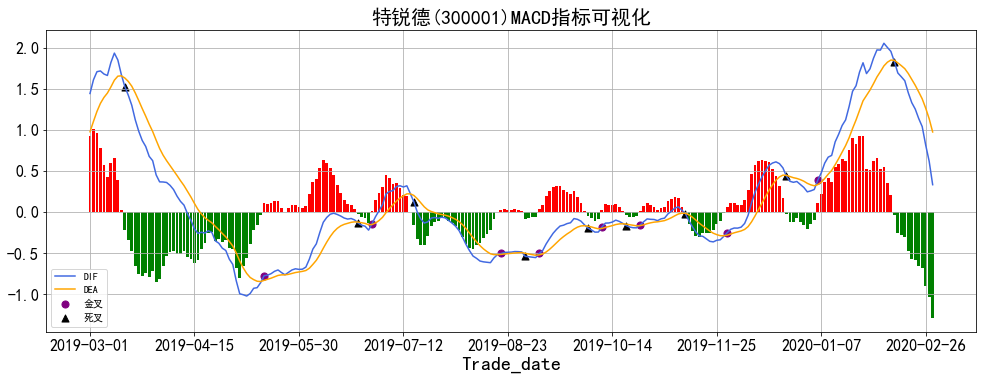

In [7]:
df=get_data("300001")
df=get_macd_data(df)
df = df[df.index>"2019-02-28"]
draw_macd(df,"特锐德(300001)")


In [41]:
df

,open,high,low,close,dif,dea,red_bar,green_bar,金叉死叉,金叉,死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,,,,
2019-03-01,23.16,24.65,22.60,23.90,1.446592,0.980518,0.932148,NaN,None,None,None,0.028033,-0.004603,-0.001674,-0.016318
2019-03-04,24.20,25.73,24.18,24.57,1.613338,1.107082,1.012511,NaN,None,None,None,-0.006919,-0.044363,0.068376,-0.029304
2019-03-05,24.59,24.68,23.70,24.40,1.712032,1.228072,0.967919,NaN,None,None,None,-0.025000,-0.022131,0.081967,-0.034836
2019-03-06,24.31,24.34,23.20,23.79,1.721185,1.326695,0.788980,NaN,None,None,None,-0.013031,0.103405,0.029844,-0.044557
2019-03-07,23.88,24.03,23.20,23.48,1.684012,1.398158,0.571708,NaN,None,None,None,0.016184,0.124361,-0.004685,-0.025980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,25.01,25.20,24.53,24.93,1.141237,1.465429,NaN,-0.648383,None,None,None,0.002808,-0.071400,NaN,NaN
2020-02-25,24.30,25.76,23.55,25.00,1.043330,1.381009,NaN,-0.675358,None,None,None,-0.068400,-0.136000,NaN,NaN
2020-02-26,24.34,24.74,23.28,23.29,0.818322,1.268472,NaN,-0.900299,None,None,None,-0.006011,NaN,NaN,NaN


In [ ]:
pd.set_option('max_rows', None)

In [ ]:
macd_jc_sc(df)

In [9]:
df.dif

trade_date
2019-03-01    0.000000
2019-03-04    0.015032
2019-03-05    0.013882
2019-03-06   -0.009005
2019-03-07   -0.033587
                ...   
2020-02-24    1.141237
2020-02-25    1.043330
2020-02-26    0.818322
2020-02-27    0.621540
2020-02-28    0.336637
Name: dif, Length: 243, dtype: float64

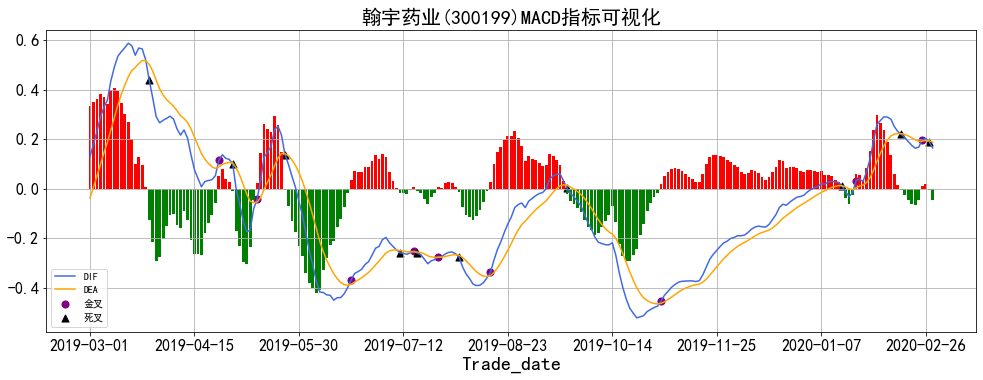

In [47]:
df=get_data("300199")
dif=get_macd_data(df)
df = df[df.index>"2019-02-28"]
draw_macd(df,"翰宇药业(300199)")

In [ ]:
df=get_data("300100.csv")
dif,red_bar,green_bar=get_macd_data(df)
draw_macd(df,red_bar,green_bar,"双林股份(300100)")

In [49]:
df.drop(columns=["open","high","low"])

,close,dif,dea,red_bar,green_bar,金叉死叉,金叉,死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,
2019-03-01,9.68,0.127969,-0.038533,0.333005,NaN,None,None,None,0.037190,0.079545,0.078512,0.160124
2019-03-04,10.04,0.179834,0.005140,0.349388,NaN,None,None,None,0.015936,0.038845,0.114542,0.133466
2019-03-05,10.20,0.231184,0.050349,0.361669,NaN,None,None,None,0.024510,0.023529,0.096078,0.094118
2019-03-06,10.45,0.288723,0.098024,0.381398,NaN,None,None,None,-0.001914,0.070813,0.076555,0.039234
2019-03-07,10.43,0.328918,0.144202,0.369431,NaN,None,None,None,0.000959,0.071908,0.067114,0.119847
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,6.69,0.167231,0.190726,NaN,-0.046991,None,None,None,0.052317,-0.004484,NaN,NaN
2020-02-25,7.04,0.196613,0.191904,0.009418,NaN,金叉,0.196613,None,-0.026989,-0.076705,NaN,NaN
2020-02-26,6.85,0.202235,0.193970,0.016531,NaN,None,None,None,-0.027737,NaN,NaN,NaN


In [52]:
output_data(df)

死叉
          1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  10.000000  9.000000  9.000000  8.000000
mean   -0.016890 -0.015566 -0.009724  0.019585
std     0.035779  0.044004  0.045656  0.123074
min    -0.100186 -0.104824 -0.059925 -0.126923
25%    -0.023375 -0.038506 -0.044304 -0.041912
50%    -0.003721 -0.005063 -0.018328 -0.011342
75%     0.002265  0.008018  0.021374  0.052996
max     0.026923  0.041071  0.065840  0.278571
1天后涨跌幅小于0天数 	 0.7
3天后涨跌幅小于0天数 	 0.5
5天后涨跌幅小于0天数 	 0.6
10天后涨跌幅小于0天数 	 0.4
金叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  9.000000  9.000000  8.000000  8.000000
mean  -0.006223 -0.017760 -0.001432 -0.035203
std    0.038025  0.038706  0.090007  0.056317
min   -0.063593 -0.076705 -0.160173 -0.124706
25%   -0.026840 -0.050114 -0.035129 -0.059029
50%   -0.020000 -0.015294 -0.026471 -0.029611
75%    0.004967  0.000000  0.071567 -0.011300
max    0.056985  0.040103  0.111288  0.054054
1天后涨跌幅大于0天数 	 0.3333333333333333
3天后涨跌幅大于0天数 	 0.2222222222222222
5天后涨跌幅大于0天数 	 0.33

,open,close,dif,dea,red_bar,green_bar,金叉死叉,金叉,死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,,
2019-03-26,11.05,10.48,0.438460,0.501493,NaN,-0.126066,死叉,None,0.43846,-0.002863,0.022901,0.065840,0.083969
2019-04-24,10.90,11.55,0.113753,0.087581,0.052342,NaN,金叉,0.113753,None,-0.026840,-0.051082,-0.160173,-0.023377
2019-04-30,10.81,10.78,0.098444,0.103993,NaN,-0.011098,死叉,None,0.098444,-0.100186,-0.104824,-0.049165,0.042672
2019-05-14,11.18,10.88,-0.043541,-0.054487,0.021892,NaN,金叉,-0.0435412,None,0.056985,0.033088,0.103860,-0.035846
2019-05-24,10.87,10.40,0.137326,0.141040,NaN,-0.007428,死叉,None,0.137326,0.026923,0.000962,-0.038462,-0.126923
2019-06-21,9.45,9.40,-0.368990,-0.386453,0.034928,NaN,金叉,-0.36899,None,-0.003191,-0.026596,-0.024468,-0.018085
2019-07-11,8.81,8.73,-0.259388,-0.250379,NaN,-0.018018,死叉,None,-0.259388,0.005727,0.008018,-0.018328,-0.034364
2019-07-17,8.78,8.78,-0.252607,-0.255327,0.005440,NaN,金叉,-0.252607,None,-0.023918,-0.050114,-0.028474,-0.046697
2019-07-18,8.75,8.57,-0.261430,-0.256547,NaN,-0.009765,死叉,None,-0.26143,-0.002334,-0.038506,-0.016336,-0.032672


In [33]:
def get_macd_data_all(df,fast_period=12,slow_period=26,signal_period=9):
    #计算快/慢速移动平均线 通过 ewm 滑动函数
    fast_ewm = df['close'].ewm(span=fast_period).mean()
    slow_ewm = df['close'].ewm(span=slow_period).mean()
    #计算 DIF 以及 DEA
    df["dif"] = fast_ewm-slow_ewm
    df["dea"]= df["dif"].ewm(span=signal_period).mean()
   
    # 计算指标金叉、死叉情况
    df['金叉死叉'] = None
    df['金叉'] = None
    df['死叉'] = None
            
    position = df['dif'] > df['dea']
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '金叉'
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉'] = df["dif"]
    position = df['dif'] < df['dea']
    df.loc[position[(position == True) & (position.shift() == False)].index, '金叉死叉'] = '死叉'
    df.loc[position[(position == True) & (position.shift() == False)].index, '死叉'] = df["dif"]
         
    # 计算N天后涨跌幅
    for i in [1, 3, 5, 10]:
        df[str(i)+'天后涨跌幅'] = df['close'].shift(-i) / df['close'] - 1
    
    return df

In [59]:
def get_data_all(code_num):
    #获取数据
    df=pd.read_csv(code_num)
    df=df.iloc[:,2:7]
    df['trade_date'] = df['trade_date'].map(lambda x:datetime.strptime(str(x),'%Y%m%d'))
    df = df.set_index('trade_date')
    data = df.sort_index()
 
    return data 

In [40]:
output_data(df_a)

死叉
            1天后涨跌幅       3天后涨跌幅       5天后涨跌幅      10天后涨跌幅
count  6000.000000  5500.000000  5500.000000  5000.000000
mean     -0.013685    -0.018009    -0.002775     0.024097
std       0.024010     0.032263     0.066815     0.110925
min      -0.049938    -0.068244    -0.103933    -0.117041
25%      -0.029614    -0.051498    -0.047619    -0.034364
50%      -0.011185    -0.012214    -0.016336    -0.005867
75%       0.004280     0.008018     0.021374     0.042672
max       0.028866     0.041071     0.162887     0.278571
1天后涨跌幅小于0天数 	 0.6666666666666666
3天后涨跌幅小于0天数 	 0.5833333333333334
5天后涨跌幅小于0天数 	 0.5
10天后涨跌幅小于0天数 	 0.4166666666666667
金叉
            1天后涨跌幅       3天后涨跌幅       5天后涨跌幅      10天后涨跌幅
count  6000.000000  6000.000000  5500.000000  5500.000000
mean     -0.001958    -0.017908     0.010484    -0.018151
std       0.038327     0.042556     0.069871     0.067908
min      -0.063593    -0.102113    -0.094190    -0.124706
25%      -0.024686    -0.040553    -0.040925    -0.061355
50%   

,open,close,dif,dea,金叉死叉,金叉,死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,
2019-03-04,9.70,10.04,0.008077,0.004487,金叉,0.00807692,None,0.015936,0.038845,0.114542,0.133466
2019-03-25,11.19,10.99,0.115367,0.115394,死叉,None,0.115367,-0.046406,-0.068244,0.012739,-0.015469
2019-04-03,11.00,11.24,0.036863,0.031990,金叉,0.0368627,None,-0.016904,-0.037367,-0.040925,-0.030249
2019-04-08,11.05,10.71,0.018151,0.030504,死叉,None,0.0181511,0.010271,0.006536,-0.047619,0.003735
2019-04-10,10.78,11.36,0.039824,0.028875,金叉,0.0398242,None,-0.051056,-0.102113,-0.094190,0.016725
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-15,5.76,5.60,0.009076,0.011285,死叉,None,0.00907623,-0.021429,0.041071,0.051786,0.278571
2020-01-21,5.94,6.29,0.031947,0.002814,金叉,0.0319468,None,-0.063593,0.000000,0.111288,0.054054
2020-02-17,6.60,6.55,0.219348,0.221483,死叉,None,0.219348,-0.004580,-0.012214,0.021374,NaN


In [64]:
df_b = pd.DataFrame()
for  i in range (1,800): 
    code = str(300000+i)
    df=get_data_all("./Desktop/text/1/"+code+".csv")
    if df.iloc[:,0].size >=300:
        df=get_macd_data_all(df)
        df_b = pd.concat([df_b, df])
    

In [62]:
df=get_data_all("./Desktop/text/1/300110.csv")

In [65]:
df_b

,open,high,low,close,dif,dea,金叉死叉,金叉,死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,,
2009-10-30,42.00,64.00,35.01,44.00,0.000000,0.000000,None,None,None,-0.100000,-0.135909,-0.115682,-0.073636
2009-11-02,39.60,41.87,39.60,39.60,-0.098718,-0.054843,死叉,None,-0.0987179,-0.068182,0.000000,-0.003030,0.035354
2009-11-03,38.20,39.36,36.15,36.90,-0.209513,-0.118233,None,None,None,0.030352,0.054472,0.028997,0.108401
2009-11-04,38.00,38.90,37.23,38.02,-0.214333,-0.150787,None,None,None,0.041557,0.038401,0.005260,0.126775
2009-11-05,38.03,40.98,37.51,39.60,-0.149568,-0.150424,金叉,-0.149568,None,-0.017424,-0.041162,-0.026263,0.134091
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,242.50,251.54,242.10,250.08,14.250728,12.544360,None,None,None,0.037188,-0.019914,NaN,NaN
2020-02-25,251.00,264.49,248.08,259.38,15.344851,13.104458,None,None,None,-0.044259,-0.078572,NaN,NaN
2020-02-26,259.00,259.30,247.30,247.90,15.111417,13.505850,None,None,None,-0.011295,NaN,NaN,NaN


In [69]:
output_data(df_b).to_csv("check_macd.csv")

死叉
             1天后涨跌幅        3天后涨跌幅        5天后涨跌幅       10天后涨跌幅
count  38932.000000  38848.000000  38827.000000  38778.000000
mean      -0.002103     -0.002639     -0.001527     -0.002910
std        0.039703      0.069587      0.091035      0.124374
min       -0.691126     -0.752949     -0.773117     -0.825293
25%       -0.018259     -0.034835     -0.044735     -0.061990
50%        0.001060     -0.001292     -0.000766     -0.006536
75%        0.016607      0.031250      0.043146      0.057830
max        0.101887      0.332374      0.611333      1.594872
1天后涨跌幅小于0天数 	 0.4663407392239173
3天后涨跌幅小于0天数 	 0.5054008395617897
5天后涨跌幅小于0天数 	 0.49938568649534143
10天后涨跌幅小于0天数 	 0.5257499744036039
金叉
             1天后涨跌幅        3天后涨跌幅        5天后涨跌幅       10天后涨跌幅
count  39316.000000  39302.000000  39274.000000  38870.000000
mean       0.001755      0.002965      0.004729      0.012642
std        0.038177      0.074922      0.106563      0.182932
min       -0.682222     -0.702336     -0.745629     -0